<a href="https://colab.research.google.com/github/dablro12/AI_study/blob/main/Lab05_Softmax%26CrossEntropyLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import glob
import random

from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio as audio
import IPython.display as ipd


# Softmax & CrossEntropy Loss

In [ ]:
y = np.array([1., 0, 0]) # 3*1 Ground Truth
y_hat = np.array([0.4, -3.2, 8.4]) #.3*1 예측값 
#softmax : exp(예측값) / 전체 exp(예측값) 합
y_hat_softmax = np.exp(y_hat)/np.sum(np.exp(y_hat))
print(y_hat_softmax)

[3.35347058e-04 9.16292993e-06 9.99655490e-01]


## 예측값에 대한 softmax함수를 사용했을 때, 특정 값으로 구해준다. 

Cross entropy loss = CEloss
![image.png](
)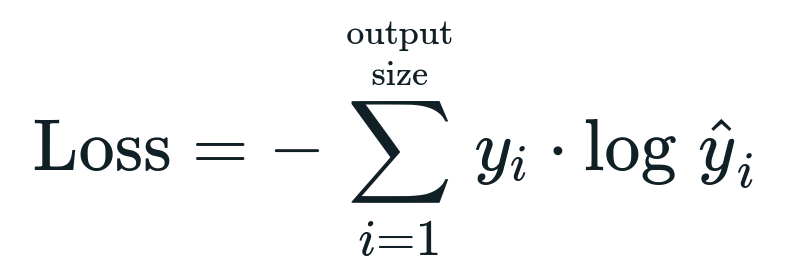

In [ ]:
y = torch.tensor([[1.,0,0]]) # Ground truth
y_hat = torch.tensor([[2,-1.2,3]]) # 예측값 

# softmax
y_hat_softmax = torch.exp(y_hat) / torch.sum(torch.exp(y_hat))
print(y_hat_softmax)

#Cross Entropy Loss #input으로 y_hat_softmax를 사용해야한다.
CEloss = -torch.sum(y*torch.log(y_hat_softmax))
print(CEloss)

tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.3242)


# 직접 softmax랑 Cross Entropy loss를 직접안해도됌

torch.softmax 함수
torch.nn : Loss 모델 



In [ ]:
y = torch.tensor([[1.,0,0]])
y_hat = torch.tensor([[2,-1.2,3]])

# Softmax
y_hat_softmax = y_hat.softmax(dim=1) # 예측값을 소프트맥스함수로 바로 반환 
print(y_hat_softmax)

#cross entropy loss
CEloss = nn.CrossEntropyLoss() #torch.nn.CrossEntropyLoss() 메소드 이용
print(CEloss(y_hat_softmax, torch.argmax(y, dim=1)))
print(CEloss(y_hat, y))
print(CEloss(y_hat, torch.argmax(y, dim=1)))

tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.2102)
tensor(1.3242)
tensor(1.3242)


#1. wav 음성파일을 받을 수 있는 데이터로드를 만들고, 
#2. 데이터를 가지고 와 파형으로 확인하고, 
#3. 훈련시켜서 

In [ ]:
#googlem drive mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
voice_list = glob.glob('Homework1/*_me.wav')
music_list = glob.glob('Homework1/*_music.wav')
print(len(voice_list),len(music_list))

In [ ]:
def mywav_iter(batch_size, flist, L):
    N = len(flist)
    inds = list(range(N))
    random.shuffle(inds)
    
    for i in range(0, N, batch_size):
        batch_inds = inds[i:min(i+batch_size, N)]
        batch_wavs = np.zeros((len(batch_inds),L))
        batch_lbls = np.zeros((len(batch_inds),1))
    
        for bi in range(0, len(batch_inds)):
            d = wavfile.read(flist[batch_inds[bi]])
            if len(d[1].shape)>1:
                ds = d[1][::6,0]
            else:
                ds = d[1][::6]
                
            t0 = np.random.randint(0, ds.shape[0]-L, 1)[0]
            l = flist[batch_inds[bi]].split('.wav')[-2].split('_')[-1]
            batch_wavs[bi] = ds[t0:t0+L] + np.random.randn(L)*0.1
            batch_wavs[bi] = (batch_wavs[bi]-np.mean(batch_wavs[bi]))/np.std(batch_wavs[bi])
                
            if l=='me':
                batch_lbls[bi] = 1
            elif l=='music':
                batch_lbls[bi] = 0

        yield batch_wavs, batch_lbls

In [ ]:
batch_size = 4
flist = voice_list + music_list
L = 4000
fs = 8000

In [ ]:
data_iter = mywav_iter(batch_size, flist, L)
for x,y in data_iter:
    print(x.shape, y.shape)
    for i in range(len(x)):
        ipd.display(audio(x[i],rate=fs))
        print(y[i])
        plt.plot(x[i])
        plt.show()
        break
    break

In [ ]:
num_epoch = 1000
L = 4000
batch_size = 16
lr = 0.001

## ******모델의 아키텍쳐 히든 레이어에 활성함수 뭐썼는지, 레이어 갯수가 몇개인지 확인하기
# L -> 2L -> ReLU -> 2L -> 2
model = nn.Sequential(nn.Linear(L, 2*L),nn.ReLU(),nn.Linear(2*L,2))
# CrossEntropyLoss 함수에서는 Softmax를 자동적으로 해줌으로 Softamx를 해줄 필요는 없다.   
loss = nn.CrossEntropyLoss(reduction='mean')
#torch.optim.SGD : Strochastic Gradinet Descent 알고리즘을 이용해 파라미터를 업데이트 해줄 것이다.
alg = torch.optim.SGD(model.parameters(),lr)

loss_train_epoch = []
loss_valid_epoch = []

flist = voice_list[:32] + music_list[:32]
flist_vd = voice_list[32:39] + music_list[32:39]

# loop for learning
for j in np.arange(0,num_epoch):
  # training
  data_iter = mywav_iter(batch_size, flist, L) # data를 batch 사이즈만큼 가지고 옴
  loss_train = [] 
  model.train() # 모델 훈련시킨다라고 신호를 줌 
  for batch_X,batch_y in data_iter:
    batch_X = torch.tensor(batch_X).float() #batch_X에 대해 float 자료형으로 tensor로 바꿔줌 
    batch_y = torch.tensor(batch_y).long().squeeze() #batch_y에 대해 차원 축소하고, long 자료형으로 tensor로 바꿔줌 
    y_hat = model(batch_X)           # 1. forward
    l = loss(y_hat, batch_y)         # 2. loss calculation
    l.backward()                     # 3. backward
    alg.step()                       # 4. parameter update
    alg.zero_grad()                  # 업데이트 했으므로 Gradient를 0으로 초기화해주기
    loss_train.append(l.detach()) #loss값을 loss_train 변수에 저장 
  loss_train_epoch.append(torch.mean(torch.stack(loss_train))) #epcoh당 나오는 loss값을 loss_tarin_epoch 변수에 저장 

  # validationd : 
  data_iter_vd = mywav_iter(batch_size, flist_vd, L)
  loss_valid = []
  model.eval() # 모델 평가한다고 신호를 줌 
  for batch_X,batch_y in data_iter_vd:
    batch_X = torch.tensor(batch_X).float()
    batch_y = torch.tensor(batch_y).long().squeeze()
    with torch.no_grad():
    #!!!!!!!평가할떄는 forward, loss cal만 해준다 backward 및 파라미터 업데이트는 할 필요 없음!!!!!!
      y_hat = model(batch_X)         # 1. forward
      l = loss(y_hat, batch_y)       # 2. loss calculation
    loss_valid.append(l.detach())
  loss_valid_epoch.append(torch.mean(torch.stack(loss_valid)))

  if j%10==0:
    print(f'Epoch {j} loss_train {loss_train_epoch[-1]:.4f} loss_valid {loss_valid_epoch[-1]:.4f}')

In [ ]:
plt.subplot(121)
plt.plot(loss_train_epoch, label='train loss')
plt.axis([0,num_epoch,0,1])
plt.xlabel('epoch')
plt.legend()
plt.subplot(122)
plt.plot(loss_valid_epoch, label='valid loss')
plt.legend()
plt.axis([0,num_epoch,0,1])
plt.xlabel('epoch')
plt.show()


# Inference

In [ ]:
j=3
#print(flist_vd[j])
d = wavfile.read(flist_vd[j])
if len(d[1].shape)>1:
    ds = d[1][::6,0]
else:
    ds = d[1][::6]
ds = torch.tensor(ds).float()
prob_0 = torch.zeros_like(torch.tensor(ds))
prob_1 = torch.zeros_like(torch.tensor(ds))
for n in np.arange(0,len(ds)-L,L//16):
    ds_seg = ds[n:n+L]
    ds_seg = (ds_seg-torch.mean(ds_seg))/torch.std(ds_seg)
    y_hat = model(ds_seg)
    y_hat = torch.softmax(y_hat, dim=0)
    prob_0[n:n+L//16] = y_hat[0]
    prob_1[n:n+L//16] = y_hat[1]

In [ ]:
plt.subplot(211)
plt.plot(ds)
plt.subplot(212)
plt.plot(prob_1,label='me')
plt.plot(prob_0,':',label='music')
plt.legend()
plt.show()